# GP

In [1]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
#%matplotlib widget


# Setup environment collect data

In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="rgb_array")

# Dynamics from GP

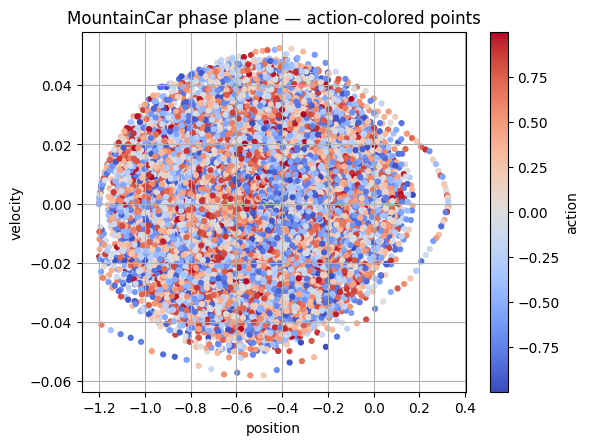

In [62]:
# =========================================================
# MountainCar: Phase plane with action color + dynamics field
# - 2D (pos, vel) scatter colored by action
# - Quiver arrows showing empirical mean (Δpos, Δvel) per bin
# - Marginal histograms for position and velocity
# =========================================================
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

SEED = 0
TOTAL_STEPS = 100000
BINS_POS = 35
BINS_VEL = 35
ARROW_STRIDE = 2        # thin-out arrows for readability
USE_POLICY = ["swing", "random"]    # "swing" or "random"
USE_BOTH_DATA = False


rng = np.random.default_rng(SEED)

# ---------- simple policies ----------
def random_policy(space):
    low, high = space.low.item(), space.high.item()
    return np.array([rng.uniform(low, high)], dtype=np.float32)

def swing_up_policy(obs, space):
    pos, vel = float(obs[0]), float(obs[1])
    a = np.sign(vel)                       # push in direction of motion
    #a = 0.95 * a + 0.15                    # slight right bias
    low, high = space.low.item(), space.high.item()
    return np.array([np.clip(a, low, high)], dtype=np.float32)

# ---------- rollouts ----------
def collect(n_steps=TOTAL_STEPS, policy="swing"):
    env = gym.make("MountainCarContinuous-v0")
    obs, _ = env.reset(seed=SEED)
    pos, vel, act, dpos, dvel = [], [], [], [], []


    if USE_BOTH_DATA:
        for training in USE_POLICY:
            for _ in range(n_steps):
                if training=="swing":
                    a = swing_up_policy(obs, env.action_space)
                else:
                    a = random_policy(env.action_space)
                nxt, r, term, trunc, _ = env.step(a)

                pos.append(float(obs[0])); vel.append(float(obs[1])); act.append(float(a[0]))
                dpos.append(float(nxt[0] - obs[0])); dvel.append(float(nxt[1] - obs[1]))
                obs = nxt
                if term or trunc:
                    obs, _ = env.reset()
    else:
        for _ in range(n_steps):
            #a = swing_up_policy(obs, env.action_space)
            a = random_policy(env.action_space)
            nxt, r, term, trunc, _ = env.step(a)

            pos.append(float(obs[0])); vel.append(float(obs[1])); act.append(float(a[0]))
            dpos.append(float(nxt[0] - obs[0])); dvel.append(float(nxt[1] - obs[1]))
            obs = nxt
            if term or trunc:
                obs, _ = env.reset()



    env.close()
    pos = np.asarray(pos); vel = np.asarray(vel); act = np.asarray(act)
    dpos = np.asarray(dpos); dvel = np.asarray(dvel)
    return pos, vel, act, dpos, dvel

pos, vel, act, dpos, dvel = collect(policy=USE_POLICY)

fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.12, 0.12, 0.6, 0.6])

norm = TwoSlopeNorm(vcenter=0.0, vmin=act.min(), vmax=act.max())
pts = ax.scatter(pos, vel, c=act, s=12, cmap="coolwarm", norm=norm)

ax.set_xlabel("position")
ax.set_ylabel("velocity")
ax.set_title("MountainCar phase plane — action-colored points")

cb = plt.colorbar(pts, ax=ax)
cb.set_label("action")
plt.grid()
plt.show()


# GP MODEL NEW

# CELL A

In [63]:
import numpy as np, torch, gpytorch
device = torch.device("cuda")

# You already have these from your rollouts:
# pos, vel, act, dpos, dvel  (all 1D numpy arrays of equal length)
# If they are Python lists, np.asarray(...) is fine.

X_np = np.column_stack([pos, vel, act]).astype(np.float32)   # (N,3)
Y_np = np.column_stack([dpos, dvel]).astype(np.float32)      # (N,2)

Xtr  = torch.tensor(X_np, device=device)
Ytr  = torch.tensor(Y_np, device=device)

# Per-dimension standardization (inputs & outputs)
X_mu, X_std = Xtr.mean(0), Xtr.std(0).clamp_min(1e-6)
Y_mu, Y_std = Ytr.mean(0), Ytr.std(0).clamp_min(1e-6)

Xz = (Xtr - X_mu) / X_std              # (N,3)
Yz = (Ytr - Y_mu) / Y_std              # (N,2)

N = Xz.shape[0]
print("N =", N, "| Xz:", Xz.shape, "| Yz:", Yz.shape, "| device:", device)


N = 100000 | Xz: torch.Size([100000, 3]) | Yz: torch.Size([100000, 2]) | device: cuda


# CELL B

In [64]:
import math
from gpytorch.variational import (
    VariationalStrategy, CholeskyVariationalDistribution, LMCVariationalStrategy
)

num_tasks   = 2      # Δpos, Δvel
num_latents = 2      # latent GPs in LMC head (tune: 1–3)
M           = 128    # inducing points (tune: 64–512)

# Simple grid of inducing points in standardized space (you can KMeans instead)
with torch.no_grad():
    mins = Xz.min(0).values
    maxs = Xz.max(0).values
    g0 = torch.linspace(mins[0], maxs[0], int(M**(1/3))+2, device=device)
    g1 = torch.linspace(mins[1], maxs[1], int(M**(1/3))+2, device=device)
    g2 = torch.linspace(mins[2], maxs[2], int(M**(1/3))+2, device=device)
    G  = torch.stack(torch.meshgrid(g0, g1, g2, indexing="ij"), dim=-1).reshape(-1,3)
    inducing_points = G[torch.linspace(0, len(G)-1, M).round().long()].contiguous()  # (M,3)

# Model
class LMC_MTSVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents=2, num_tasks=2):
        # batch over latents: (Q, M, D)
        inducing_points = inducing_points.unsqueeze(0).expand(num_latents, -1, -1)
        q_u = CholeskyVariationalDistribution(
            inducing_points.size(-2),
            batch_shape=torch.Size([num_latents])
        )
        base_vs = VariationalStrategy(
            self, inducing_points, q_u, learn_inducing_locations=True
        )
        lmc_vs = LMCVariationalStrategy(
            base_vs, num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1
        )
        super().__init__(lmc_vs)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = LMC_MTSVGP(inducing_points.to(device), num_latents=num_latents, num_tasks=num_tasks).to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, "M params (approx)")


0.033802 M params (approx)


# CELL C

In [65]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [66]:
import tqdm

model.train(); likelihood.train()

opt = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 0.08},
    {'params': likelihood.parameters(), 'lr': 0.05},
])

# Variational ELBO needs num_data for minibatches; here we do full-batch
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Yz.size(0))

E = 800   # epochs
pbar = tqdm.tqdm(range(E))
for e in pbar:
    opt.zero_grad()
    out = model(Xz)
    loss = -mll(out, Yz)
    loss.backward()
    opt.step()

    if (e+1) % 100 == 0:
        # Report per-task lengthscales / noise
        ls = model.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        noise = likelihood.task_noises.detach().mean().item() if hasattr(likelihood, "task_noises") else float('nan')
        pbar.set_description(f"ELBO {loss.item():.3f} | ls~{ls:.3f} | noise~{noise:.4f}")

model.eval(); likelihood.eval()


ELBO -2.987 | ls~1.981 | noise~0.0067: 100%|██████████| 800/800 [01:42<00:00,  7.81it/s]


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

# CELL D

In [67]:
@torch.no_grad()
def gp_predict_delta(pos_batch, vel_batch, act_batch, sample=False):
    """
    Inputs: 1D numpy or torch, same length (B,)
    Returns:
      mean_dpos, mean_dvel, std_dpos, std_dvel  (np arrays)
      If sample=True, also returns one sampled (dpos, dvel) draw via rsample().
    """
    if not torch.is_tensor(pos_batch):
        Xb = torch.tensor(np.column_stack([pos_batch, vel_batch, act_batch]),
                          dtype=torch.float32, device=device)
    else:
        Xb = torch.stack([pos_batch, vel_batch, act_batch], dim=-1).to(device).float()
    Xb_z = (Xb - X_mu) / X_std

    model.eval(); likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        pred = likelihood(model(Xb_z))  # MultitaskMultivariateNormal with 2 outputs
        mean = pred.mean                # (B, 2)
        var  = pred.variance            # (B, 2)

        # de-standardize
        mean = mean * Y_std + Y_mu
        std  = var.clamp_min(1e-12).sqrt() * Y_std

        m_dp = mean[..., 0].detach().cpu().numpy()
        m_dv = mean[..., 1].detach().cpu().numpy()
        s_dp = std[..., 0].detach().cpu().numpy()
        s_dv = std[..., 1].detach().cpu().numpy()

        if not sample:
            return m_dp, s_dp, m_dv, s_dv

        # one reparameterized sample from the predictive (per point)
        sample_mv = pred.rsample()                     # (B, 2)
        sample_np = (sample_mv * Y_std + Y_mu).detach().cpu().numpy()
        return m_dp, s_dp, m_dv, s_dv, sample_np[:,0], sample_np[:,1]

def gp_step(state_batch, action_batch, dt=1.0, stochastic=False):
    """
    Vectorized one-step model for MPPI:
      state_batch: (B,2) [pos, vel]
      action_batch: (B,) or (B,1)
    Returns next_state mean (B,2) and optionally a sample (B,2) if stochastic=True.
    """
    sb = torch.as_tensor(state_batch, device=device, dtype=torch.float32)
    ab = torch.as_tensor(action_batch, device=device, dtype=torch.float32).view(-1)
    pos_b, vel_b = sb[:,0], sb[:,1]

    if stochastic:
        m_dp, _, m_dv, _, s_dp_samp, s_dv_samp = gp_predict_delta(pos_b, vel_b, ab, sample=True)
        dpos = s_dp_samp; dvel = s_dv_samp
    else:
        m_dp, _, m_dv, _ = gp_predict_delta(pos_b, vel_b, ab, sample=False)
        dpos = m_dp; dvel = m_dv

    nxt = np.stack([pos_b.detach().cpu().numpy() + dpos*dt,
                    vel_b.detach().cpu().numpy() + dvel*dt], axis=-1)
    return nxt


# CELL E

In [68]:
# GP dynamics adapter for MPPI:
# - Expects your trained multitask SVGP "model" and "likelihood"
# - Uses your standardization stats: X_mu, X_std, Y_mu, Y_std  (from Cell A)
# - Provides: step_batch(states, actions, stochastic=False)  -> next_states

import numpy as np
import torch, gpytorch

class SVGPDynamics:
    def __init__(self, model, likelihood, X_mu, X_std, Y_mu, Y_std, device=None):
        self.model = model.eval()
        self.lik   = likelihood.eval()
        self.X_mu  = X_mu
        self.X_std = X_std.clamp_min(1e-6)
        self.Y_mu  = Y_mu
        self.Y_std = Y_std.clamp_min(1e-6)
        self.device = device or next(model.parameters()).device

    @torch.no_grad()
    def _predict_delta(self, Xq):  # Xq: (B,3) tensor on device
        Xqz = (Xq - self.X_mu) / self.X_std
        with gpytorch.settings.fast_pred_var():
            post = self.lik(self.model(Xqz))              # multitask posterior
        mean = post.mean * self.Y_std + self.Y_mu         # (B,2) de-standardized
        var  = post.variance.clamp_min(1e-12) * (self.Y_std**2)
        return mean, var

    @torch.no_grad()
    def step_batch(self, states, actions, stochastic=False, dt=1.0):
        """
        states:  (B,2) [pos, vel]  (np or torch)
        actions: (B,) or (B,1)     (np or torch)
        returns next_states (B,2)  numpy
        """
        if not torch.is_tensor(states):
            S = torch.as_tensor(states,  dtype=torch.float32, device=self.device)
        else:
            S = states.to(self.device).float()
        if not torch.is_tensor(actions):
            A = torch.as_tensor(actions, dtype=torch.float32, device=self.device).view(-1, 1)
        else:
            A = actions.to(self.device).float().view(-1, 1)

        Xq = torch.cat([S, A], dim=1)                     # (B,3)
        mean, var = self._predict_delta(Xq)               # (B,2), (B,2)

        if stochastic:
            std = var.sqrt()
            eps = torch.randn_like(std)
            d = mean + eps * std                          # sampled delta
        else:
            d = mean                                      # mean delta

        S_next = S + d * dt
        return S_next.detach().cpu().numpy()


In [69]:
# === Cell F — build the GP dynamics adapter to use inside GP_MPPI ===
dyn = SVGPDynamics(
    model, likelihood,      # trained multitask SVGP from Cells B–C
    X_mu, X_std, Y_mu, Y_std,
    device=device
)


# COST FUNCTION

In [70]:
GOAL = 0.45
NEAR_EPS = 0.03   # when x >= GOAL-NEAR_EPS, switch to "hold mode"

def v_desired(p, vmax=0.06):
    # swing-up bias when far: wants positive velocity toward goal
    return vmax * np.tanh(5.0 * (GOAL - p))

def running_cost_far(p, v, a):
    # FAR zone: build momentum & go right
    w_pos = 80.0
    w_vel = 8.0
    w_act = 0.12
    pos_gap = np.maximum(0.0, GOAL - p)
    v_err   = v - v_desired(p)
    return w_pos*pos_gap**2 + w_vel*v_err**2 + w_act*a**2

def running_cost_near(p, v, a):
    # tighten these two knobs if you still overshoot
    OVERSHOOT_BARRIER = 3_000.0   # barrier strength
    OVERSHOOT_HARD    = 1_200.0   # quadratic one-sided penalty
    
    # Track x*=GOAL, v=0, a~0, and strongly punish overshoot (x > GOAL)
    w_x   = 900.0
    w_v   = 500.0
    w_act = 0.05

    # one-sided penalty only when x>GOAL
    overshoot = np.maximum(0.0, p - GOAL)
    quad_wall = OVERSHOOT_HARD * overshoot**2

    # soft log barrier just beyond the goal (kicks in quickly after 0.45)
    # add a small eps to avoid log(0)
    eps = 1e-3
    log_barrier = OVERSHOOT_BARRIER * np.log1p(overshoot/eps)

    return w_x*(p-GOAL)**2 + w_v*(v**2) + w_act*(a**2) + quad_wall + log_barrier


def step_cost(p, v, a):
    # pick cost mode based on position
    return np.where(p >= GOAL-NEAR_EPS,
                    running_cost_near(p, v, a),
                    running_cost_far(p, v, a))

def terminal_cost(p):
    # modest terminal bonus for arriving; main “stay” reward comes from NEAR cost
    return np.where(p >= GOAL, -200.0, 0.0)


In [71]:
class GP_MPPI:
    def __init__(self, horizon=80, n_samples=1024, lambda_=1.3,
                 u_sigma=0.55, action_low=-1.0, action_high=1.0,
                 sample_gp=False, seed=0, warm_start=True,
                 smooth_weight=2.0,
                 dynamics_adapter=None): 
        self.T = horizon
        self.K = n_samples
        self.lmb = lambda_
        self.u_sigma_base = u_sigma
        self.a_low, self.a_high = action_low, action_high
        self.sample_gp = sample_gp
        self.rng = np.random.default_rng(seed)
        self.smooth_w = float(smooth_weight)
        self.dyn = dynamics_adapter


        self.U = np.zeros((self.T, 1), dtype=np.float32)
        if warm_start:
            # brief left push, then right push (helps swing-up)
            self.U[:12, 0]  = -0.95
            self.U[12:30, 0] = +0.95

    def plan(self, s0):
        p0, v0 = float(s0[0]), float(s0[1])

        # reduce exploration if we are already near goal (helps holding)
        near_now = (p0 >= GOAL - NEAR_EPS) and (abs(v0) < 0.02)
        u_sigma  = self.u_sigma_base * (0.35 if near_now else 1.0)

        eps = self.rng.normal(0.0, u_sigma, size=(self.K, self.T, 1)).astype(np.float32)
        U_samples = np.clip(self.U[None, :, :] + eps, self.a_low, self.a_high)  # (K,T,1)

        # rollout buffers
        P = np.full((self.K,), p0, dtype=np.float32)
        V = np.full((self.K,), v0, dtype=np.float32)
        costs = np.zeros((self.K,), dtype=np.float32)

        # previous action for smoothness (start from nominal u0)
        u_prev = U_samples[:, 0, 0].copy()

        # Track if/when we enter NEAR zone; after that, use NEAR cost
        in_near = (P >= GOAL-NEAR_EPS)

        for t in range(self.T):
            At = U_samples[:, t, 0]                               # (K,)

            # --- NEW: one batched GP step for all K rollouts at time t ---
            assert self.dyn is not None, "Pass dynamics_adapter=SVGPDynamics(...) to GP_MPPI"
            S_curr = np.stack([P, V], axis=1)                     # (K,2)
            S_next = self.dyn.step_batch(S_curr, At,              # (K,2) next state
                                        stochastic=self.sample_gp, dt=1.0)
            P, V = S_next[:, 0].astype(np.float32), S_next[:, 1].astype(np.float32)


            # once a trajectory is near, keep it in NEAR cost mode thereafter
            in_near = np.logical_or(in_near, P >= GOAL-NEAR_EPS)

            # running cost (zone-specific) + action smoothness
            c_run = np.where(in_near, running_cost_near(P, V, At),
                                       running_cost_far(P, V, At))
            c_smooth = self.smooth_w * (At - u_prev)**2
            costs += (c_run + c_smooth).astype(np.float32)

            u_prev = At

        # terminal bonus (small)
        costs += terminal_cost(P).astype(np.float32)

        # MPPI update
        J = costs - costs.min()
        w = np.exp(-J / self.lmb)
        w /= (w.sum() + 1e-12)
        dU = (w[:, None, None] * eps).sum(axis=0)                 # (T,1)
        self.U = np.clip(self.U + dU, self.a_low, self.a_high)

        u0 = float(self.U[0, 0])
        self.U[:-1] = self.U[1:]
        self.U[-1] = 0.0
        return u0


In [72]:
# ---------- hold-at-goal wrapper ----------
class HoldAtSetpointWrapper(gym.Wrapper):
    def __init__(self, env, x_star=0.45, pos_tol=0.001, v_tol=0.0003, hold_steps=12):
        super().__init__(env)
        self.x_star = float(x_star)
        self.pos_tol = float(pos_tol)
        self.v_tol = float(v_tol)
        self.hold_steps_req = int(hold_steps)
        self._hold = 0
        # keep the original goal position for reference (Gym env stores it here)
        self.goal_position = float(getattr(env.unwrapped, "goal_position", x_star))

    def reset(self, **kw):
        self._hold = 0
        return self.env.reset(**kw)

    def step(self, action):
        s_next, r, terminated, truncated, info = self.env.step(action)
        x, v = float(s_next[0]), float(s_next[1])
        near = abs(x - self.x_star) <= self.pos_tol
        slow = abs(v) <= self.v_tol
        # count consecutive steps meeting both position + velocity tolerance
        self._hold = self._hold + 1 if (near and slow) else 0
        # only mark episode done if we've held for required steps
        if terminated:
            terminated = (self._hold >= self.hold_steps_req)
        return s_next, r, terminated, truncated, info

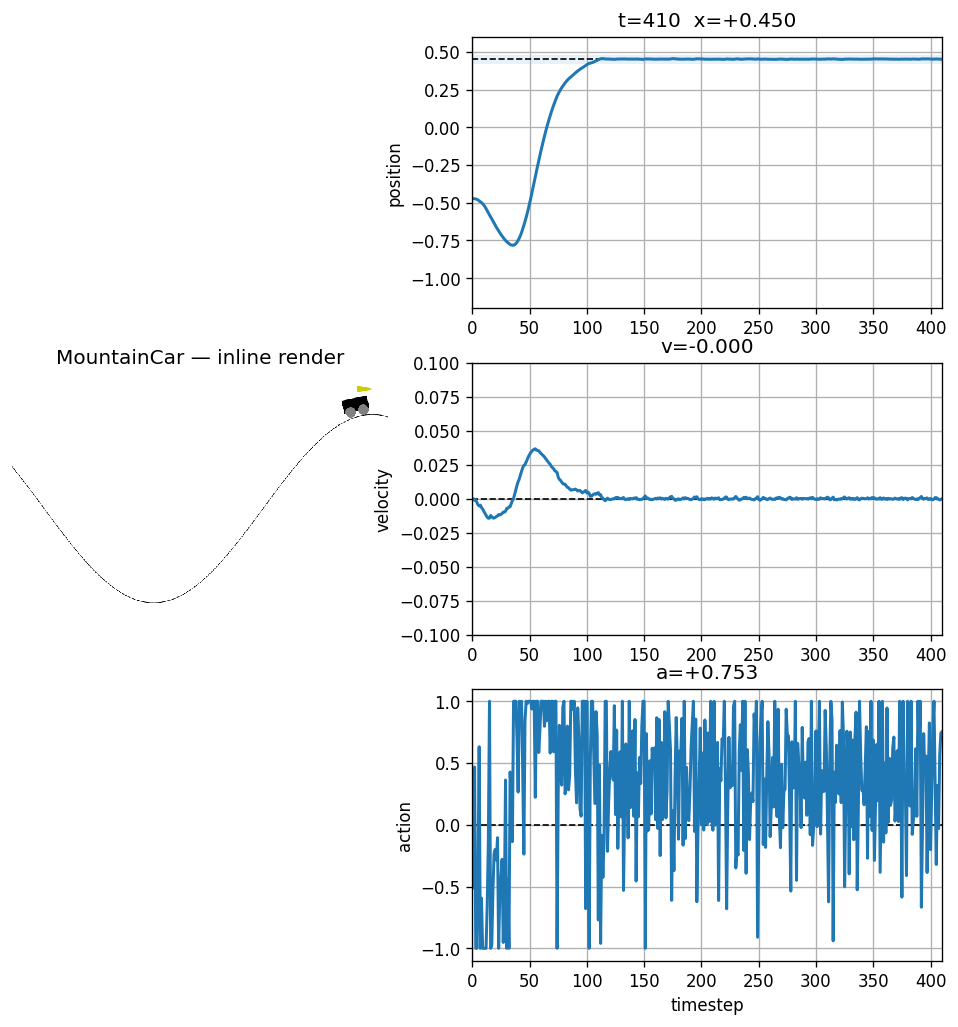

In [ ]:
# === Inline env render + live plots (frame + x/v/a) ===
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ---- goal band params (reuse your values) ----
GOAL = 0.45
NEAR_EPS = 0.03

# ---- make env with rgb frames for inline imshow ----
base_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
env = HoldAtSetpointWrapper(base_env, x_star=GOAL, pos_tol=0.008, v_tol=0.003, hold_steps=12)
obs, _ = env.reset(seed=0)

# ---- controller (uses your GP_MPPI that calls dyn.step_batch) ----
USE_STOCHASTIC_GP = False  # steadier holding near goal
ctrl = GP_MPPI(
    horizon=80, n_samples=128, lambda_=1.0,
    u_sigma=0.6, action_low=-1.0, action_high=1.0,
    sample_gp=USE_STOCHASTIC_GP, seed=0, warm_start=False,
    smooth_weight=2.0, dynamics_adapter=dyn
)

# ---- figure: left = env frame, right = x/v/a time series ----
fig = plt.figure(figsize=(10, 10), dpi=120)
gs  = fig.add_gridspec(nrows=3, ncols=2, width_ratios=[1.2, 1.5], height_ratios=[1,1,1])

ax_img = fig.add_subplot(gs[:, 0])       # spans all rows
ax_x   = fig.add_subplot(gs[0, 1])
ax_v   = fig.add_subplot(gs[1, 1])
ax_a   = fig.add_subplot(gs[2, 1])

frame0 = env.render()
im = ax_img.imshow(frame0, interpolation="nearest")
ax_img.set_axis_off()
ax_img.set_title("MountainCar — inline render")

# goal band and lines
ax_x.axhspan(GOAL-NEAR_EPS, GOAL+NEAR_EPS, alpha=0.10)
ax_x.axhline(GOAL, ls="--", lw=1, c="k")
ax_v.axhline(0.0,   ls="--", lw=1, c="k")
ax_a.axhline(0.0,   ls="--", lw=1, c="k")

line_x, = ax_x.plot([], [], lw=1.8)
line_v, = ax_v.plot([], [], lw=1.8)
line_a, = ax_a.plot([], [], lw=1.8)
ax_x.set_ylabel("position")
ax_v.set_ylabel("velocity")
ax_a.set_ylabel("action"); ax_a.set_xlabel("timestep")
for ax in (ax_x, ax_v, ax_a):
    ax.grid(True)

display(fig)

# ---- rollout loop ----
t_hist, x_hist, v_hist, a_hist, r_hist = [], [], [], [], []
done, t, TMAX = False, 0, 600

while not done and t < TMAX:
    p, v = float(obs[0]), float(obs[1])
    a_val = float(ctrl.plan((p, v)))
    nxt, r, term, trunc, _ = env.step([a_val])
    #done = term or trunc

    # update histories
    t_hist.append(t); x_hist.append(p); v_hist.append(v); a_hist.append(a_val); r_hist.append(r)
    t_arr = np.asarray(t_hist)

    # update plots
    line_x.set_data(t_arr, np.asarray(x_hist))
    line_v.set_data(t_arr, np.asarray(v_hist))
    line_a.set_data(t_arr, np.asarray(a_hist))

    # axes limits
    ax_x.set_xlim(0, max(50, t))
    ax_x.set_ylim(-1.2, 0.6)
    ax_v.set_xlim(0, max(50, t))   # keep same time window as position
    ax_v.set_ylim(-0.1, 0.1)
    ax_a.set_xlim(0, max(50, t))
    ax_a.set_ylim(-1.1, 1.1)

    # (optional) force x autoscale refresh
    for ax in (ax_v, ax_a):
        ax.relim()
        ax.autoscale_view(scalex=True, scaley=False)

    # update env frame
    im.set_data(env.render())
    ax_x.set_title(f"t={t}  x={p:+.3f}")
    ax_v.set_title(f"v={v:+.3f}")
    ax_a.set_title(f"a={a_val:+.3f}")

    clear_output(wait=True); display(fig); plt.pause(0.001)

    obs = nxt
    t += 1

env.close(); plt.close(fig)

traj = np.column_stack([t_hist, x_hist, v_hist, a_hist, r_hist]).astype(np.float32)
print(f"Finished. Steps={len(traj)} | Reached/held goal≈{done} | Return≈{traj[:,4].sum():.2f}")